# CSTR Control System Optimization Workflow
This presents the streamlined workflow for optimizing the control of a CSTR system comparing traditional static PID optimization and reinforcement learning approaches

## 1. System Overview

The project consists of these key components

* CSTR Environment: A non-linear CSTR (MIMO) model implemented as a Gym environment
* Static PID Optimization: Baseline approach using differential evolution
* Reinforcement Learning: Advanced approach using TD3, SAC, and CIRL algorithms
* Data collection: Generation of simulation data for offline trainining
* Offline training: Training RL agents without direct environment interaction

## 2. Pre-requisites

* CSTR_model_plus.py: CSTR environment implementation
* static_pid_gain.py: Static PID optimization using differential evolution
* policy_network.py: Neural network architectures for RL algorithms
* RL_algorithms.py: Implementation of TD3, SAC, and CIRL algorithms
* Replay_Buffer.py: Replay buffer for storing transitions
* gen_sim_data.py: Data generation for offline learning
* Offline_training.py: Offline training procedures


## 3. Step-by-Step Workflow

### Step 1: Set Up the CSTR Environment

The CSTR environment simulates the following:
* Two controlled variables: Concentration of B (Cb) and Volume (V)
* Two control inputs: Cooling temperature (Tc) and Inlet flow rate (Fin)
* Two PID controllers for setpoint tracking


In [3]:
from CSTR_model_plus import CSTRRLEnv

# Create environment
env = CSTRRLEnv(
    simulation_steps=150,
    dt=1,
    uncertainty_level=0.00,   # parameter uncertainty
    noise_level=0.00,         # measurement noise
    actuator_delay_steps=0,   # actuator delay
    transport_delay_steps=0,  # transport delay
    enable_disturbances=False # process disturbance
)

### Step 2: Baseline-Optimize Static PID Gains

Use differential evolution to find optimal static PID gains as a benchmark

In [4]:
from static_pid_gain import StaticPIDOptimizer, run_optimization

# Run optimization to find optimal PID gains
optimal_gains = run_optimization(env, maxiter=25, popsize=15)

# Test the optimized gains on vairous setpoint schedules
optimizer = StaticPIDOptimizer(env)
test_schedules = [
    [0.12, 0.35, 0.48, 0.71, 0.84],  # Increasing steps
    [0.86, 0.73, 0.61, 0.48, 0.25],  # Decreasing steps
    [0.25, 0.30, 0.65, 0.30, 0.25],  # Peak
    [0.86, 0.71, 0.24, 0.63, 0.82]   # Valley
]

results = optimizer.evaluate_and_plot(optimal_gains, test_schedules, save_plots=True)

Starting optimization with 25 iterations and population size 15
differential_evolution step 1: f(x)= 0.26898213295899487
differential_evolution step 2: f(x)= 0.25326794054031004
differential_evolution step 3: f(x)= 0.2528533210697036
differential_evolution step 4: f(x)= 0.2528533210697036
differential_evolution step 5: f(x)= 0.24341013583477525
differential_evolution step 6: f(x)= 0.24341013583477525
differential_evolution step 7: f(x)= 0.24341013583477525
differential_evolution step 8: f(x)= 0.24341013583477525
differential_evolution step 9: f(x)= 0.24341013583477525
differential_evolution step 10: f(x)= 0.24341013583477525
differential_evolution step 11: f(x)= 0.24341013583477525
differential_evolution step 12: f(x)= 0.24341013583477525
differential_evolution step 13: f(x)= 0.24341013583477525
differential_evolution step 14: f(x)= 0.24341013583477525
differential_evolution step 15: f(x)= 0.24341013583477525
differential_evolution step 16: f(x)= 0.24341013583477525
differential_evolut

### Step 3: Generate Dataset for Offline Training

Generate a diverse dataset for training RL agents offline

In [5]:
from gen_sim_data import DataGenerator, generate_diverse_dataset

# Create environment (same)
env = CSTRRLEnv(
    simulation_steps=150,
    dt=1.0,
    uncertainty_level=0.00,
    noise_level=0.00,
    actuator_delay_steps=0,
    transport_delay_steps=0,
    enable_disturbances=False
)

# Generate diverse dataset with multiple exploration strategies
dataset = generate_diverse_dataset(env, n_episodes=50, save_dir="./data")

100%|██████████| 12/12 [00:00<00:00, 19.59it/s]


Generated dataset with 900 transitions from 12 episodes


100%|██████████| 12/12 [00:00<00:00, 23.08it/s]


Generated dataset with 900 transitions from 12 episodes


100%|██████████| 12/12 [00:00<00:00, 15.33it/s]


Generated dataset with 900 transitions from 12 episodes


100%|██████████| 12/12 [00:00<00:00, 24.45it/s]


Generated dataset with 900 transitions from 12 episodes
Combined 4 datasets with a total of 3600 transitions
Dataset contains 3600 transitions from approximately 0 episodes
Reward statistics:
  Mean: -0.2002
  Std: 0.1661
  Min: -0.6054
  Max: -0.0000
Action statistics:
  Action 0 - Mean: 0.1881, Std: 0.4510
  Action 1 - Mean: 0.1389, Std: 0.4271
  Action 2 - Mean: 0.0697, Std: 0.4231
  Action 3 - Mean: 0.1324, Std: 0.4381
  Action 4 - Mean: 0.0682, Std: 0.4246
  Action 5 - Mean: 0.0300, Std: 0.4269
PID gains statistics:
  Kp_Cb - Mean: 12.8218, Std: 6.7644
  Ki_Cb - Mean: 11.3894, Std: 4.2709
  Kd_Cb - Mean: 5.3579, Std: 2.1112
  Kp_V - Mean: 0.5662, Std: 0.2190
  Ki_V - Mean: 1.0682, Std: 0.4246
  Kd_V - Mean: 0.5198, Std: 0.2113
Unique Cb setpoints: [0.6        0.60672853 0.61678003 0.65       0.6522109  0.65680617
 0.65823299 0.66498338 0.66964771 0.66987681 0.67423633 0.68334455
 0.68380888 0.69998031 0.7        0.70793974 0.70920801 0.71025486
 0.72572191 0.72873115 0.737191   0.

### Step 4: Train RL Agents using Offline Data

Train CIRL, TD3, and SAC agents using the generated dataset:

In [2]:
from Offline_training import train_all_agents_offline

# Train all agent types

results = train_all_agents_offline(
    dataset_path="./data/cstr_diverse_dataset.pkl",
    n_updates=20000,
    batch_size=256,
    save_dir="./results",
    seed=42,
    verbose=True
)

# # Or train a specific agent type
# from Offline_training import set_seed, load_offline_dataset, offline_train, evaluate_agent
# from RL_algorithms import create_agent
# from Replay_Buffer import ReplayBuffer
# from CSTR_model_plus import CSTRRLEnv
# import torch

# # Set random seed
# set_seed(42)

# # Create environment for evaluation
# env = CSTRRLEnv(
#     simulation_steps=150,
#     dt=1.0,
#     uncertainty_level=0.00,
#     noise_level=0.00,
#     actuator_delay_steps=0,
#     transport_delay_steps=0,
#     enable_disturbances=False
# )

# # load dataset
# dataset = load_offline_dataset("./data/cstr_diverse_dataset.pkl")

# # Create agent (choose from "td3", "sac", "cirl")
# agent_type = "cirl"
# state_dim = env.observation_space.shape[0]
# action_dim = env.action_space.shape[0]
# action_high = env.action_space.high[0]
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# agent = create_agent(agent_type, state_dim, action_dim, action_high, device)

# # Create replay buffer and load dataset
# replay_buffer = ReplayBuffer(len(dataset['states']) + 1000, state_dim, action_dim, device)
# replay_buffer.load_from_dataset(dataset)

# # Train agent
# stats = offline_train(agent, replay_buffer, n_updates=1000, batch_size=256, save_dir=f"./results/{agent_type}")

# # Evaluate agent
# mean_reward, mean_steps = evaluate_agent(agent, env, n_episodes=5, max_steps=200, verbose=True)

Loaded dataset from ./data/cstr_diverse_dataset.pkl with 3600 transitions
Using device: cuda
Loaded 3600 transitions into replay buffer (capacity: 4600)

===== Training TD3 Agent =====


Training TD3: 100%|██████████| 20000/20000 [04:31<00:00, 73.79it/s, actor_loss=5.7988, critic_loss=2.9448]


Plotting training curves...
Evaluating on setpoint schedule 1: [0.12, 0.35, 0.48, 0.71, 0.84]
  Episode 1: Reward = -50.91, Steps = 200
  Episode 2: Reward = -50.91, Steps = 200
  Episode 3: Reward = -50.91, Steps = 200
  Average for schedule 1: Reward = -50.91, Steps = 200.0
Evaluating on setpoint schedule 2: [0.86, 0.73, 0.61, 0.48, 0.25]
  Episode 1: Reward = -61.50, Steps = 200
  Episode 2: Reward = -61.50, Steps = 200
  Episode 3: Reward = -61.50, Steps = 200
  Average for schedule 2: Reward = -61.50, Steps = 200.0
Evaluating on setpoint schedule 3: [0.25, 0.3, 0.65, 0.3, 0.25]
  Episode 1: Reward = -21.74, Steps = 200
  Episode 2: Reward = -21.74, Steps = 200
  Episode 3: Reward = -21.74, Steps = 200
  Average for schedule 3: Reward = -21.74, Steps = 200.0
Evaluating on setpoint schedule 4: [0.86, 0.71, 0.24, 0.63, 0.82]
  Episode 1: Reward = -76.72, Steps = 200
  Episode 2: Reward = -76.72, Steps = 200
  Episode 3: Reward = -76.72, Steps = 200
  Average for schedule 4: Reward = 

Training SAC: 100%|██████████| 20000/20000 [06:04<00:00, 54.88it/s, actor_loss=2028.1100, critic_loss=4.7036]   


Plotting training curves...
Evaluating on setpoint schedule 1: [0.12, 0.35, 0.48, 0.71, 0.84]
  Episode 1: Reward = -20.64, Steps = 200
  Episode 2: Reward = -20.64, Steps = 200
  Episode 3: Reward = -20.64, Steps = 200
  Average for schedule 1: Reward = -20.64, Steps = 200.0
Evaluating on setpoint schedule 2: [0.86, 0.73, 0.61, 0.48, 0.25]
  Episode 1: Reward = -32.65, Steps = 200
  Episode 2: Reward = -32.65, Steps = 200
  Episode 3: Reward = -32.65, Steps = 200
  Average for schedule 2: Reward = -32.65, Steps = 200.0
Evaluating on setpoint schedule 3: [0.25, 0.3, 0.65, 0.3, 0.25]
  Episode 1: Reward = -11.19, Steps = 200
  Episode 2: Reward = -11.19, Steps = 200
  Episode 3: Reward = -11.19, Steps = 200
  Average for schedule 3: Reward = -11.19, Steps = 200.0
Evaluating on setpoint schedule 4: [0.86, 0.71, 0.24, 0.63, 0.82]
  Episode 1: Reward = -36.69, Steps = 200
  Episode 2: Reward = -36.69, Steps = 200
  Episode 3: Reward = -36.69, Steps = 200
  Average for schedule 4: Reward = 

Training CIRL: 100%|██████████| 20000/20000 [04:11<00:00, 79.67it/s, actor_loss=-4.1480, critic_loss=0.9370]


Plotting training curves...
Evaluating on setpoint schedule 1: [0.12, 0.35, 0.48, 0.71, 0.84]
  Episode 1: Reward = -50.91, Steps = 200
  Episode 2: Reward = -50.91, Steps = 200
  Episode 3: Reward = -50.91, Steps = 200
  Average for schedule 1: Reward = -50.91, Steps = 200.0
Evaluating on setpoint schedule 2: [0.86, 0.73, 0.61, 0.48, 0.25]
  Episode 1: Reward = -61.50, Steps = 200
  Episode 2: Reward = -61.50, Steps = 200
  Episode 3: Reward = -61.50, Steps = 200
  Average for schedule 2: Reward = -61.50, Steps = 200.0
Evaluating on setpoint schedule 3: [0.25, 0.3, 0.65, 0.3, 0.25]
  Episode 1: Reward = -21.74, Steps = 200
  Episode 2: Reward = -21.74, Steps = 200
  Episode 3: Reward = -21.74, Steps = 200
  Average for schedule 3: Reward = -21.74, Steps = 200.0
Evaluating on setpoint schedule 4: [0.86, 0.71, 0.24, 0.63, 0.82]
  Episode 1: Reward = -76.72, Steps = 200
  Episode 2: Reward = -76.72, Steps = 200
  Episode 3: Reward = -76.72, Steps = 200
  Average for schedule 4: Reward = 

### Step 5: Fine-tune RL Agents Online

Further improve the pre-trained RL agents through idrect environment interactions

Error loading model: [Errno 2] No such file or directory: './results/td3/td3_offline_final'
Starting with a freshly initialized model


  0%|          | 0/100 [00:00<?, ?it/s]

Episode 5/100 | Reward: -12.11 | Buffer: 750/10000 | Noise: 0.292:   5%|▌         | 5/100 [00:03<01:39,  1.05s/it]


Evaluation at episode 5: Reward = -38.11, Steps = 150.0


Episode 10/100 | Reward: -8.68 | Buffer: 1500/10000 | Noise: 0.282:  10%|█         | 10/100 [00:15<03:29,  2.33s/it]


Evaluation at episode 10: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_10


Episode 15/100 | Reward: -30.09 | Buffer: 2250/10000 | Noise: 0.272:  15%|█▌        | 15/100 [00:27<03:33,  2.51s/it]


Evaluation at episode 15: Reward = -38.11, Steps = 150.0


Episode 20/100 | Reward: -34.24 | Buffer: 3000/10000 | Noise: 0.262:  20%|██        | 20/100 [00:39<03:22,  2.53s/it]


Evaluation at episode 20: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_20


Episode 25/100 | Reward: -52.00 | Buffer: 3750/10000 | Noise: 0.252:  25%|██▌       | 25/100 [00:51<03:10,  2.54s/it]


Evaluation at episode 25: Reward = -38.11, Steps = 150.0


Episode 30/100 | Reward: -26.80 | Buffer: 4500/10000 | Noise: 0.242:  30%|███       | 30/100 [01:03<02:56,  2.52s/it]


Evaluation at episode 30: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_30


Episode 35/100 | Reward: -20.69 | Buffer: 5250/10000 | Noise: 0.232:  35%|███▌      | 35/100 [01:14<02:43,  2.52s/it]


Evaluation at episode 35: Reward = -38.11, Steps = 150.0


Episode 40/100 | Reward: -18.26 | Buffer: 6000/10000 | Noise: 0.222:  40%|████      | 40/100 [01:26<02:31,  2.53s/it]


Evaluation at episode 40: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_40


Episode 45/100 | Reward: -55.06 | Buffer: 6750/10000 | Noise: 0.212:  45%|████▌     | 45/100 [01:38<02:16,  2.48s/it]


Evaluation at episode 45: Reward = -38.11, Steps = 150.0


Episode 50/100 | Reward: -32.57 | Buffer: 7500/10000 | Noise: 0.202:  50%|█████     | 50/100 [01:50<02:05,  2.50s/it]


Evaluation at episode 50: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_50


Episode 55/100 | Reward: -27.59 | Buffer: 8250/10000 | Noise: 0.192:  55%|█████▌    | 55/100 [02:01<01:50,  2.46s/it]


Evaluation at episode 55: Reward = -38.11, Steps = 150.0


Episode 60/100 | Reward: -10.91 | Buffer: 9000/10000 | Noise: 0.182:  60%|██████    | 60/100 [02:13<01:39,  2.48s/it]


Evaluation at episode 60: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_60


Episode 65/100 | Reward: -12.46 | Buffer: 9750/10000 | Noise: 0.172:  65%|██████▌   | 65/100 [02:24<01:26,  2.48s/it]


Evaluation at episode 65: Reward = -38.11, Steps = 150.0


Episode 70/100 | Reward: -9.57 | Buffer: 10000/10000 | Noise: 0.162:  70%|███████   | 70/100 [02:36<01:13,  2.44s/it] 


Evaluation at episode 70: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_70


Episode 75/100 | Reward: -50.62 | Buffer: 10000/10000 | Noise: 0.152:  75%|███████▌  | 75/100 [02:47<01:00,  2.41s/it]


Evaluation at episode 75: Reward = -38.11, Steps = 150.0


Episode 80/100 | Reward: -54.49 | Buffer: 10000/10000 | Noise: 0.142:  80%|████████  | 80/100 [02:58<00:48,  2.43s/it]


Evaluation at episode 80: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_80


Episode 85/100 | Reward: -18.25 | Buffer: 10000/10000 | Noise: 0.132:  85%|████████▌ | 85/100 [03:10<00:36,  2.41s/it]


Evaluation at episode 85: Reward = -38.11, Steps = 150.0


Episode 90/100 | Reward: -23.25 | Buffer: 10000/10000 | Noise: 0.122:  90%|█████████ | 90/100 [03:21<00:24,  2.41s/it]


Evaluation at episode 90: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_90


Episode 95/100 | Reward: -52.51 | Buffer: 10000/10000 | Noise: 0.112:  95%|█████████▌| 95/100 [03:32<00:12,  2.40s/it]


Evaluation at episode 95: Reward = -38.11, Steps = 150.0


Episode 100/100 | Reward: -21.66 | Buffer: 10000/10000 | Noise: 0.102: 100%|██████████| 100/100 [03:43<00:00,  2.24s/it]


Evaluation at episode 100: Reward = -38.11, Steps = 150.0
Saved checkpoint to ./results/fine_tuned_td3/models/td3_episode_100


Fine-tuning complete. Final model saved to ./results/fine_tuned_td3/td3_fine_tuned_final


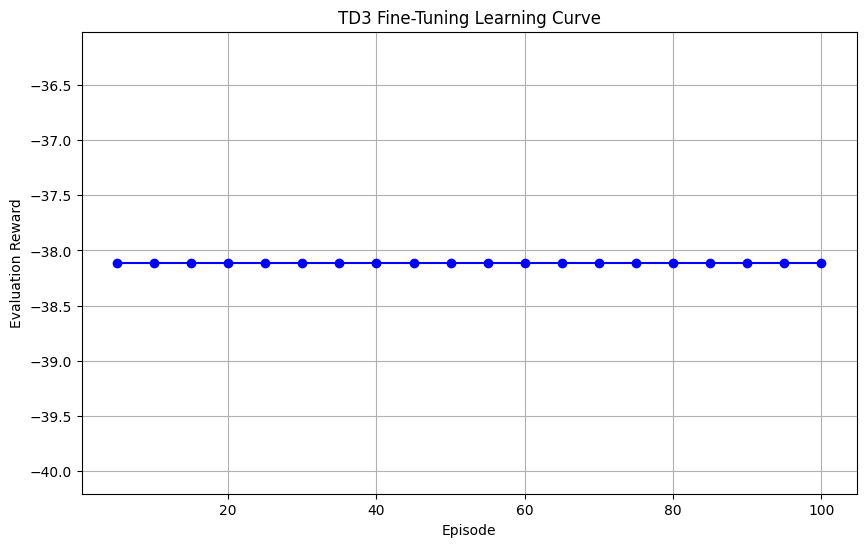

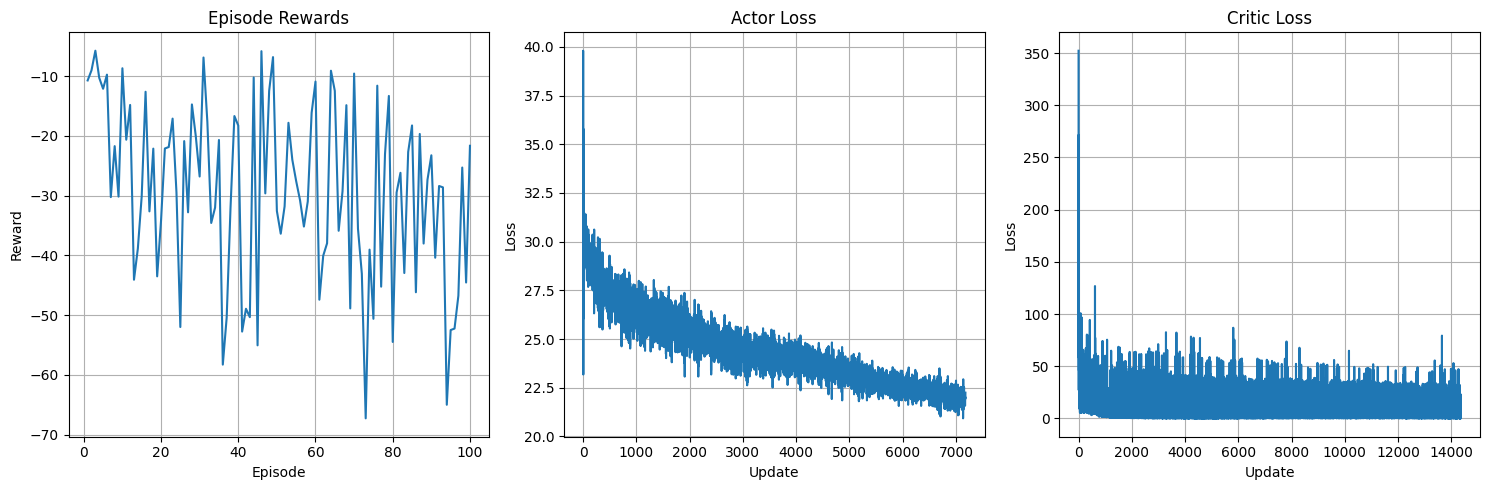

In [5]:
from online_fine_tuning import online_fine_tune, load_agent
from CSTR_model_plus import CSTRRLEnv
import torch

# Set up a more challenging environment for fine-tuning
env = CSTRRLEnv(
    simulation_steps=150,
    dt=1.0,
    uncertainty_level=0.00,     # Higher uncertainty
    noise_level=0.00,          # Higher noise
    actuator_delay_steps=0,    # Increased delays
    transport_delay_steps=0,
    enable_disturbances=False   # Enable disturbances
)

# Load a pre-trained agent
agent_type = "td3"  # Choose from: "td3", "sac", "cirl"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_high = env.action_space.high[0]

agent = load_agent(
    agent_type, 
    f"./results/{agent_type}/{agent_type}_offline_final",
    state_dim, action_dim, action_high, device
)

# Fine-tune the agent
fine_tuning_stats = online_fine_tune(
    agent=agent,
    env=env,
    n_episodes=100,
    max_steps=200,
    batch_size=64,
    buffer_size=10000,
    init_exploration=0.3,
    final_exploration=0.1,
    save_dir=f"./results/fine_tuned_{agent_type}",
    save_interval=10,
    eval_interval=5,
    eval_episodes=3,
    render=False,
    device=device,
    verbose=True
)

### Step 6: Evaluate and Compare all Approaches

Comprehensitvely evalaute all controllers on various setpoint tracking scenarios:

In [6]:
from evaluate_controllers import evaluate_all_controllers

# Run evaluation with all controllers
evaluator = evaluate_all_controllers(
    static_pid_path="./results/static_pid/optimal_pid_gains.npy",
    td3_path="./results/td3/td3_offline_final",
    sac_path="./results/sac/sac_offline_final",
    cirl_path="./results/cirl/cirl_offline_final",
    pso_path="./results/pso/best_policy.npy",  # If PSO was run
    save_dir="./results/evaluation",
    difficulty="easy",  # Choose from: "easy", "medium", "hard", "extreme"
    n_episodes=5,
    render=False,
    verbose=True
)

# Generate setpoint tracking plots
for scenario in ["Increasing", "Decreasing", "Peak", "Valley", "Step", "Random"]:
    evaluator.plot_setpoint_tracking(scenario, save_plots=True, show_plots=True)

# Generate comparative metrics plots
evaluator.plot_comparative_metrics(save_plots=True, show_plots=True)
evaluator.plot_controller_heatmap(metric="reward", save_plots=True, show_plots=True)
evaluator.plot_controller_heatmap(metric="mse", save_plots=True, show_plots=True)

# Generate statistical report
report = evaluator.generate_statistical_report(baseline_controller="Static PID")
print(report)

Loading Static PID gains from ./results/static_pid/optimal_pid_gains.npy
Error loading Static PID gains: [Errno 2] No such file or directory: './results/static_pid/optimal_pid_gains.npy'
Loading TD3 model from ./results/td3/td3_offline_final
Error loading TD3 model: [Errno 2] No such file or directory: './results/td3/td3_offline_final'
Loading SAC model from ./results/sac/sac_offline_final
Error loading SAC model: [Errno 2] No such file or directory: './results/sac/sac_offline_final'
Loading CIRL model from ./results/cirl/cirl_offline_final
Error loading CIRL model: [Errno 2] No such file or directory: './results/cirl/cirl_offline_final'
Loading PSO policy from ./results/pso/best_policy.npy
Error loading PSO policy: [Errno 2] No such file or directory: './results/pso/best_policy.npy'

Evaluation complete. Results saved to ./results/evaluation/evaluation_results.pkl
No evaluation results available. Run evaluate_setpoint_tracking first.
No evaluation results available. Run evaluate_setpo